<a href="https://colab.research.google.com/github/bindhu520/Safe-driving-Challenge-ML-PROECT-/blob/master/Sdc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files

# Data import


In [1]:
train = pd.read_csv('/content/drive/My Drive/Project_12/Dataset/train.csv')
test = pd.read_csv('/content/drive/My Drive/Project_12/Dataset/test.csv')
exp = pd.read_csv('/content/drive/My Drive/Project_12/Dataset/example_submission.csv')


NameError: ignored

# Library Import

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

from sklearn.svm import LinearSVC # Linear Support Vector Classigication
from sklearn.svm import NuSVC

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

In [0]:
len(train)

NameError: ignored

# Data preprocessing

In [0]:
new_df = pd.DataFrame()  # Subset

noalert = train.index[train['IsAlert'] == 0]
turnnoalert = train.iloc[noalert-1][train['IsAlert'] == 1] # The change moment data


#new_df 

for i in turnnoalert.index: # Return 500ms before and after the moment
    new_df = new_df.append(train[i-5:i+6])
    
new_df = new_df.drop_duplicates() # Drop Dupicate instances

#new_df
sum(new_df.isna())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


TypeError: ignored

In [0]:
pcadata = new_df.drop(columns = ['TrialID', 'ObsNum', 'IsAlert']) # Drop unneccessary columns

# Standarization

X_scaled = preprocessing.scale(pcadata) 
pcadata.info()

# Principle Component Analysis

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37421 entries, 604323 to 604318
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   P1      37421 non-null  float64
 1   P2      37421 non-null  float64
 2   P3      37421 non-null  int64  
 3   P4      37421 non-null  float64
 4   P5      37421 non-null  float64
 5   P6      37421 non-null  int64  
 6   P7      37421 non-null  float64
 7   P8      37421 non-null  int64  
 8   E1      37421 non-null  float64
 9   E2      37421 non-null  float64
 10  E3      37421 non-null  int64  
 11  E4      37421 non-null  int64  
 12  E5      37421 non-null  float64
 13  E6      37421 non-null  int64  
 14  E7      37421 non-null  int64  
 15  E8      37421 non-null  int64  
 16  E9      37421 non-null  int64  
 17  E10     37421 non-null  int64  
 18  E11     37421 non-null  float64
 19  V1      37421 non-null  float64
 20  V2      37421 non-null  float64
 21  V3      37421 non-null  int64

In [0]:
pcadata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37421 entries, 604323 to 604318
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   P1      37421 non-null  float64
 1   P2      37421 non-null  float64
 2   P3      37421 non-null  int64  
 3   P4      37421 non-null  float64
 4   P5      37421 non-null  float64
 5   P6      37421 non-null  int64  
 6   P7      37421 non-null  float64
 7   P8      37421 non-null  int64  
 8   E1      37421 non-null  float64
 9   E2      37421 non-null  float64
 10  E3      37421 non-null  int64  
 11  E4      37421 non-null  int64  
 12  E5      37421 non-null  float64
 13  E6      37421 non-null  int64  
 14  E7      37421 non-null  int64  
 15  E8      37421 non-null  int64  
 16  E9      37421 non-null  int64  
 17  E10     37421 non-null  int64  
 18  E11     37421 non-null  float64
 19  V1      37421 non-null  float64
 20  V2      37421 non-null  float64
 21  V3      37421 non-null  int64

In [0]:
pca=PCA() 
pca.fit(X_scaled)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

shape of X_pca (37421, 30)


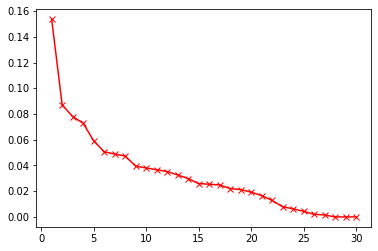

In [0]:
X_pca=pca.transform(X_scaled) 
#let's check the shape of X_pca array
print ("shape of X_pca", X_pca.shape)
#%%
# Scree Plot
y = pca.explained_variance_ratio_

x = np.array([i for i in range(1, len(y)+1)])

plt.plot(x, y, 'r-x')

# Filter principle components

In [0]:
sum(pca.explained_variance_ratio_[:14])
X_pca = X_pca[:,:14] # Slice the first 14 features
X_pca.shape 

X_pca # Training features
new_df.IsAlert # Target features


604323    1
604324    1
604325    1
604326    1
604327    1
         ..
604314    0
604315    0
604316    0
604317    0
604318    1
Name: IsAlert, Length: 37421, dtype: int64

In [0]:
skf = StratifiedKFold(n_splits=10)
params = {}
nb = GaussianNB()
gs = GridSearchCV(nb, cv=skf, param_grid=params, return_train_score=True)

x_train, x_test, y_train, y_test = train_test_split(X_pca, new_df.IsAlert, random_state = 42)

NameError: ignored

In [0]:
# Nu - SVC
nusvc = NuSVC(gamma = 'scale')
nusvcgridsearch = GridSearchCV(nusvc, cv = skf, param_grid = params, return_train_score = True)
nusvcgridsearch.fit(x_train, y_train)

NameError: ignored

In [0]:
nusvcgridsearch.cv_results_

In [0]:
nusvcgridsearch.score(X_pca, new_df.IsAlert)

In [0]:
nusvc_predict = nusvcgridsearch.predict(X_pca)
confusion_matrix(new_df.IsAlert, nusvc_predict)

In [0]:
roc_auc_score(new_df.IsAlert, nusvc_predict)

In [0]:
from sklearn.svm import SVR
from sklearn.svm import SVC

# epsilon - SVR


In [0]:
svr = SVR(gamma='scale', C=1.0, epsilon=0.2)
svrgridsearch = GridSearchCV(svr, cv = skf, param_grid = params, return_train_score = True)
svrgridsearch.fit(x_train, y_train)

In [0]:
svrgridsearch.cv_results_

In [0]:
svrgridsearch.score(X_pca, new_df.IsAlert)

In [0]:
svr_predict = svrgridsearch.predict(X_pca)

confusion_matrix(new_df.IsAlert, svr_predict)

In [0]:
roc_auc_score(new_df.IsAlert, svr_predict)

In [0]:
# C - SVC
svc = SVC(gamma='auto')
svcgridsearch = GridSearchCV(svc, cv = skf, param_grid = params, return_train_score = True)
svcgridsearch.fit(x_train, y_train)

In [0]:
svcgridsearch.cv_results_

In [0]:
svcgridsearch.score(X_pca, new_df.IsAlert)

In [0]:
svc_predict = svcgridsearch.predict(X_pca)
confusion_matrix(new_df.IsAlert, svc_predict)

In [0]:
roc_auc_score(new_df.IsAlert, svc_predict)


In [0]:
from sklearn.neural_network import MLPClassifier

nn1 = MLPClassifier(solver='adam', alpha=1e-5,activation = 'logistic',hidden_layer_sizes=(14, 14, 12, 10, 5), random_state=1)
nngridsearch = GridSearchCV(nn1, cv = skf, param_grid = params, return_train_score = True)

In [0]:
nngridsearch.fit(x_train, y_train)

In [0]:
nngridsearch.cv_results_

In [0]:
nngridsearch.score(X_pca, new_df.IsAlert)

In [0]:
nn_predict = nngridsearch.predict(X_pca)

confusion_matrix(new_df.IsAlert, nn_predict)

In [0]:
roc_auc_score(new_df.IsAlert, nn_predict)

Model 2

Use rolling means and std of each attribute as new features


In [0]:
#train_2 = train[train['TrialID'] <= 1]
train_new = pd.DataFrame() # New df
#train_new
for i in range(0, max(train.TrialID)+1): # Within each trial
    temp_data = train[train['TrialID'] == i] # Create a temporary df for each trial
    for j in list(train)[3:]: # For all the attributes of each trial
#        print (train_2[train_2['TrialID'] == i][j])
        temp_data['m{}'.format(j)] = train[train['TrialID'] == i][j].rolling(window = 5).mean() # Create the Rolling mean
        temp_data['sd{}'.format(j)] = train[train['TrialID'] == i][j].rolling(window = 5).std() # Create the Rolling Std
    train_new = train_new.append(temp_data)

In [0]:
train_new = train_new.fillna(0) # Missing Value

# Data partition


In [0]:
train_new = train_new.drop(columns = ['TrialID', 'ObsNum', 'IsAlert']) # Drop unneccessary columns

X_train, X_test, y_train, y_test = train_test_split(train_new, train.IsAlert, test_size = 0.2, random_state = 23)

In [0]:
train_new

# Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators = 50, random_state = 42)
forest.fit(X_train, y_train)

# Accuracy

In [0]:
forest.score(X_test, y_test)

In [0]:
for_predict = forest.predict(X_test)


In [0]:
# Confusion Matrix
confusion_matrix(y_test, for_predict)

In [0]:
#AUC score
roc_auc_score(y_test, for_predict)


In [0]:
from sklearn.linear_model import LogisticRegression


In [0]:
logr = LogisticRegression(random_state=0, solver='saga').fit(X_train, y_train)


In [0]:
logr.score(X_test, y_test)


In [0]:
logr_pred = logr.predict(X_test)

In [0]:
confusion_matrix(y_test, logr_pred)

In [0]:
roc_auc_score(y_test, logr_pred)

Naïve Bayes



In [0]:
from sklearn.naive_bayes import GaussianNB

In [0]:
nb2 = GaussianNB()
nb2.fit(X_train, y_train)

In [0]:
nb2.score(X_test, y_test)

In [0]:
nb2_pred = nb2.predict(X_test)

In [0]:
confusion_matrix(y_test, nb2_pred)

In [0]:
roc_auc_score(y_test, nb2_pred)

Nu-SVC

In [0]:
nusvc2 = NuSVC(gamma = 'scale')

In [0]:
nusvc2.fit(X_train, y_train)

In [0]:
nusvc2.score(X_test, y_test)

In [0]:
nusvc2_pred = nusvc2.predict(X_test)

In [0]:
confusion_matrix(y_test, nusvc2_pred)

In [0]:
roc_auc_score(y_test, nb2_pred)

Linear-SVC

In [0]:
from sklearn.svm import LinearSVC
lisvc2 = LinearSVC(random_state=42, tol=1e-5)

In [0]:
lisvc2.fit(X_train, y_train)

In [0]:
lisvc2.score(X_test, y_test)

In [0]:
lisvc2_pred = lisvc2.predict(X_test)

In [0]:
confusion_matrix(y_test, lisvc2_pred)

In [0]:
roc_auc_score(y_test, lisvc2_pred)

C-SVC

In [0]:
from sklearn.svm import SVC 

svc2 = SVC(gamma='auto')

In [0]:
svc2.fit(X_train, y_train)

In [0]:
svc2_pred = svc2.predict(X_test)

In [0]:
svc2.score(X_test, y_test)

In [0]:
confusion_matrix(y_test, svc2_pred)

In [0]:
roc_auc_score(y_test, svc2_pred)

Neural Network

With four hidden layers 90 - 70 - 50 - 30

In [0]:
from sklearn.neural_network import MLPClassifier

In [0]:
nn2 = MLPClassifier(solver='adam', alpha=1e-5,activation = 'logistic',hidden_layer_sizes=(90, 70, 50, 30), random_state=1)
nn2.fit(X_train, y_train)

In [0]:
nn2_predict = nn2.predict(X_test)


In [0]:
nn2.score(X_test, y_test)

In [0]:
confusion_matrix(y_test, nn2_predict)

In [0]:
roc_auc_score(y_test, nn2_predict)

Model & Data exportation

In [0]:
# Data export

train_new['IsAlert'] = train['IsAlert']
# train_new.to_csv('featuredtrain.csv')

In [0]:
from joblib import dump, load

# Export randomforest
# dump(forest, 'mstdforest.joblib')

In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"

In [0]:
base_dir = root_dir + 'fastai-v3/'

In [0]:
from pathlib import Path
path = Path(base_dir + 'data/bears')
dest = path/'featuretrain.csv'
dest.mkdir(parents=True, exist_ok=True)

In [0]:
train_new.to_csv('featuredtrain.csv') # Dataset exportation

In [0]:
dump(forest, 'mstdforest.joblib') # Model exportation
dump(nn2, 'mstdnn.joblib')

In [0]:
t_sc = preprocessing.scale(train_new) # Standarization
pca_2=PCA() 
pca_2.fit(t_sc)  # Fit PCA

In [0]:
t_pca=pca_2.transform(t_sc)

In [0]:
# Scree plot
y = pca_2.explained_variance_ratio_

x = np.array([i for i in range(1, len(y)+1)])

plt.plot(x, y, 'r-x')

In [0]:
# Filter principle components
sum(pca_2.explained_variance_ratio_[:30])


#X_pca # Training features
#new_df.IsAlert # Target features

In [0]:
t_pca = t_pca[:,:14] # Slice the first 14 features
t_pca.shape